In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
tf.__version__

'2.13.0'

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=15,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   fill_mode='nearest',
                                   horizontal_flip = True)

In [6]:
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/chest_xray/train',
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 shuffle = True,
                                                 class_mode = 'categorical')

Found 5261 images belonging to 2 classes.


In [7]:
validation_datagen=ImageDataGenerator(rescale=1./255)

In [8]:
validation_set=validation_datagen.flow_from_directory('/content/drive/MyDrive/chest_xray/val',
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 shuffle = True,
                                                 class_mode = 'categorical')

Found 16 images belonging to 2 classes.


Shape of first batch images: (32, 224, 224, 3)
Shape of first batch labels: (32, 2)


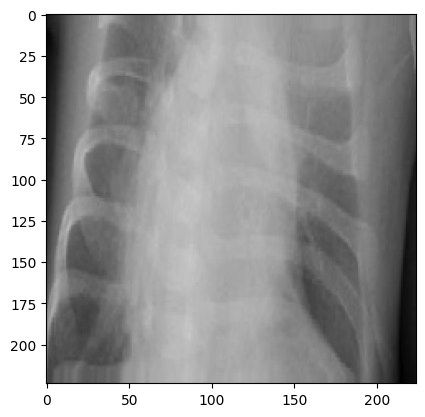

In [ ]:
first_batch_images = training_set[0][0]
first_batch_labels = training_set[0][1]


print("Shape of first batch images:", first_batch_images.shape)
print("Shape of first batch labels:", first_batch_labels.shape)

plt.imshow(training_set[1][0][1])

In [ ]:
print(training_set[1][1])

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import Callback,EarlyStopping

In [10]:
train_dir="/content/drive/MyDrive/chest_xray/train"
train_class_counts={}
classes=os.listdir(train_dir)
for name in classes:
    train_class_dir = os.path.join(train_dir, name)
    num_images = len(os.listdir(train_class_dir))
    train_class_counts[name] = num_images

In [ ]:
print(train_class_counts)

{'PNEUMONIA': 3889, 'NORMAL': 1372}


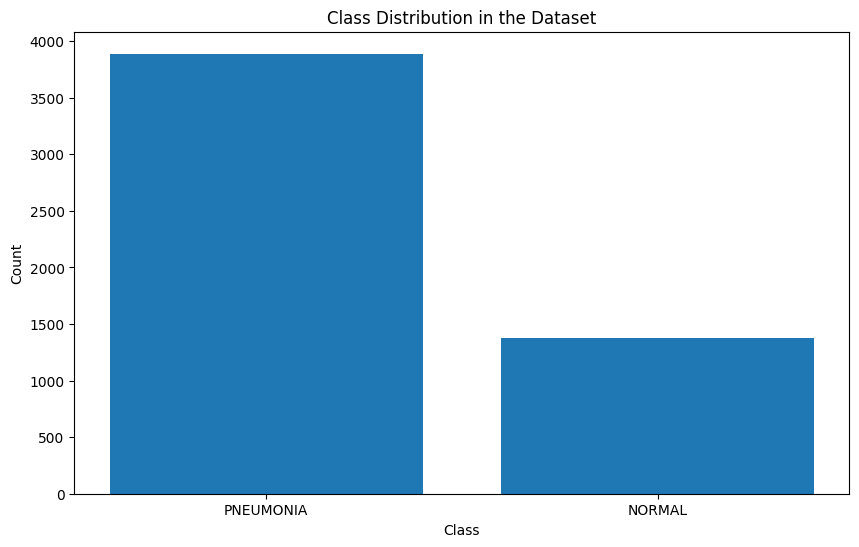

In [ ]:
train_class_names=train_class_counts.keys()
train_class_cnt=train_class_counts.values()
plt.figure(figsize=(10, 6))
plt.bar(train_class_names, train_class_cnt)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in the Dataset')
plt.show()

In [ ]:
img_size=224
num_channel=3
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.applications.vgg16 import VGG16

image_input = Input(shape=(img_size,img_size,num_channel))
vgg_mod = VGG16(input_tensor=image_input, include_top=False,weights='imagenet')
vgg_mod.trainable = False
vgg_mod.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

add_model = Sequential([
    Flatten(input_shape=vgg_mod.output_shape[1:]),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2,activation='sigmoid')
])

model_vgg16=Model(inputs=vgg_mod.input,outputs=add_model(vgg_mod.output))
model_vgg16.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'],)
model_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
from keras.callbacks import ReduceLROnPlateau

callbacks_list = [ReduceLROnPlateau(monitor='loss',factor=0.2,patience=3)]

In [ ]:
hist_1=model_vgg16.fit(training_set,
                       batch_size=32,
                       epochs=10,
                       validation_data=validation_set,
                       callbacks = callbacks_list,
                       verbose=1)

Epoch 1/10
165/165 [==============================] - 456s 3s/step - loss: 0.4663 - accuracy: 0.7854 - val_loss: 0.5386 - val_accuracy: 0.6875 - lr: 0.0100
Epoch 2/10
165/165 [==============================] - 121s 731ms/step - loss: 0.3017 - accuracy: 0.8668 - val_loss: 0.5041 - val_accuracy: 0.7500 - lr: 0.0100
Epoch 3/10
165/165 [==============================] - 123s 747ms/step - loss: 0.2438 - accuracy: 0.9044 - val_loss: 0.5896 - val_accuracy: 0.7500 - lr: 0.0100
Epoch 4/10
165/165 [==============================] - 124s 751ms/step - loss: 0.2416 - accuracy: 0.9048 - val_loss: 0.5182 - val_accuracy: 0.8125 - lr: 0.0100
Epoch 5/10
165/165 [==============================] - 122s 737ms/step - loss: 0.2206 - accuracy: 0.9093 - val_loss: 0.5222 - val_accuracy: 0.7500 - lr: 0.0100
Epoch 6/10
165/165 [==============================] - 124s 752ms/step - loss: 0.2143 - accuracy: 0.9164 - val_loss: 0.5211 - val_accuracy: 0.7500 - lr: 0.0100
Epoch 7/10
165/165 [=============================

In [11]:
test_datagen=ImageDataGenerator(rescale=1./255)
test_set=validation_datagen.flow_from_directory('/content/drive/MyDrive/chest_xray/test',
                                                 target_size = (224,224),
                                                 batch_size = 32,
                                                 shuffle = True,
                                                 class_mode = 'categorical')

Found 624 images belonging to 2 classes.


In [ ]:
loss,accuracy=model_vgg16.evaluate(test_set)

20/20 [==============================] - 88s 5s/step - loss: 0.2547 - accuracy: 0.9022


In [ ]:
print("TEST loss is ",loss)
print("TEST Accuracy ",accuracy)

TEST loss is  0.25470423698425293
TEST Accuracy  0.9022436141967773


In [ ]:
model_vgg16.save("/content/drive/MyDrive/MODEL/VGGmodel.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model_vgg16.save("/content/drive/MyDrive/MODEL/VGGmodelKeras.keras")

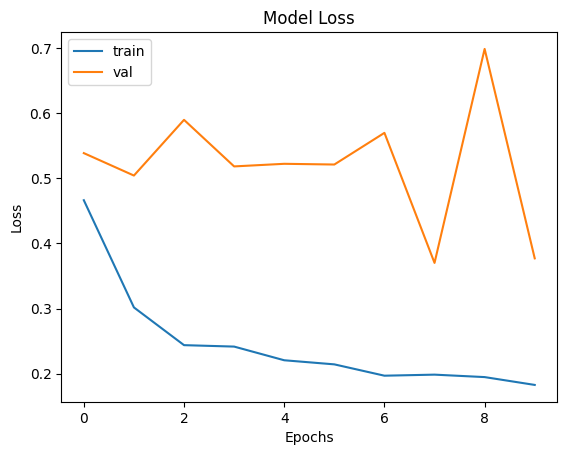

In [ ]:
plt.plot(hist_1.history['loss'])
plt.plot(hist_1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

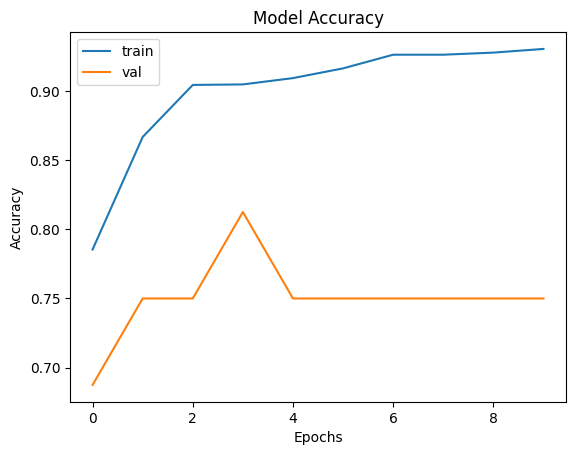

In [ ]:
plt.plot(hist_1.history['accuracy'])
plt.plot(hist_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

EFFICIENT NET


In [12]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.models import Model

In [13]:
img_size=224
num_channel=3
image_input = Input(shape=(img_size,img_size,num_channel))
effi_mod = EfficientNetB0(input_tensor=image_input, include_top=False,weights='imagenet')
effi_mod.trainable = False
effi_mod.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescal

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

add_model = Sequential([
    Flatten(input_shape=effi_mod.output_shape[1:]),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2,activation='sigmoid')
])

effi_model=Model(inputs=effi_mod.input,outputs=add_model(effi_mod.output))
effi_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'],)
effi_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]']   

In [17]:
hist_2=effi_model.fit(training_set,
                       batch_size=32,
                       epochs=10,
                       validation_data=validation_set,
                       callbacks = callbacks_list,
                       verbose=1)

Epoch 1/10
165/165 [==============================] - 1418s 8s/step - loss: 1.3780 - accuracy: 0.7069 - val_loss: 0.7048 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10
165/165 [==============================] - 127s 770ms/step - loss: 0.6069 - accuracy: 0.7392 - val_loss: 0.7515 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/10
165/165 [==============================] - 131s 794ms/step - loss: 0.5904 - accuracy: 0.7390 - val_loss: 0.7873 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/10
165/165 [==============================] - 130s 786ms/step - loss: 0.5781 - accuracy: 0.7392 - val_loss: 0.8064 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/10
165/165 [==============================] - 130s 785ms/step - loss: 0.5884 - accuracy: 0.7392 - val_loss: 0.8089 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/10
165/165 [==============================] - 130s 787ms/step - loss: 0.5773 - accuracy: 0.7392 - val_loss: 0.8123 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 7/10
165/165 [============================

In [18]:
model2_loss,model2_accuracy=effi_model.evaluate(test_set)

20/20 [==============================] - 142s 7s/step - loss: 0.6918 - accuracy: 0.6250


In [19]:
effi_model.save("/content/drive/MyDrive/MODEL/EFFI_model.h5")
effi_model.save("/content/drive/MyDrive/MODEL/EFFI_model.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


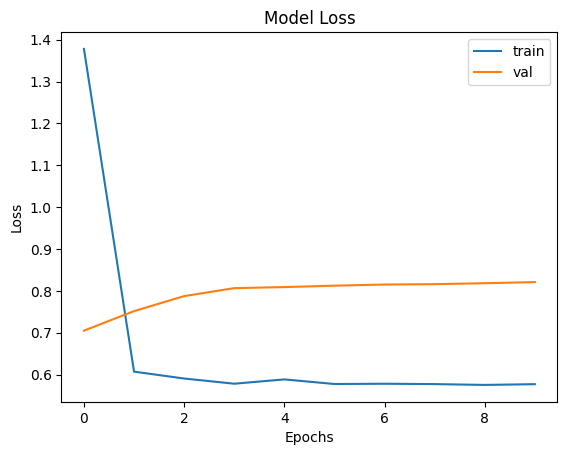

In [20]:
plt.plot(hist_2.history['loss'])
plt.plot(hist_2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

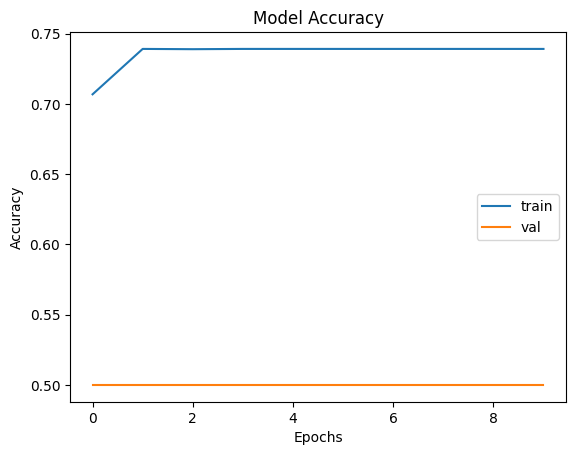

In [21]:
plt.plot(hist_2.history['accuracy'])
plt.plot(hist_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

RES NET50


In [22]:
from tensorflow.keras.applications import ResNet50

In [23]:
res_model = ResNet50(input_tensor=image_input,weights='imagenet', include_top=False)
res_model.trainable=False
res_model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                      

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

add_model = Sequential([
    Flatten(input_shape=res_model.output_shape[1:]),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2,activation='sigmoid')
])

res_model=Model(inputs=res_model.input,outputs=add_model(res_model.output))
res_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
res_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [25]:
hist_3=res_model.fit(training_set,
                       batch_size=32,
                       epochs=10,
                       validation_data=validation_set,
                       callbacks = callbacks_list,
                       verbose=1)

Epoch 1/10
165/165 [==============================] - 139s 807ms/step - loss: 0.8127 - accuracy: 0.7149 - val_loss: 0.7019 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 2/10
165/165 [==============================] - 131s 790ms/step - loss: 0.6192 - accuracy: 0.7390 - val_loss: 0.7247 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 3/10
165/165 [==============================] - 132s 802ms/step - loss: 0.5952 - accuracy: 0.7392 - val_loss: 0.7494 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 4/10
165/165 [==============================] - 134s 813ms/step - loss: 0.5839 - accuracy: 0.7392 - val_loss: 0.7704 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 5/10
165/165 [==============================] - 132s 798ms/step - loss: 0.5786 - accuracy: 0.7394 - val_loss: 0.7865 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 6/10
165/165 [==============================] - 131s 793ms/step - loss: 0.5770 - accuracy: 0.7392 - val_loss: 0.7981 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 7/10
165/165 [==========================

In [26]:
model3_loss,model3_accuracy=res_model.evaluate(test_set)

20/20 [==============================] - 7s 362ms/step - loss: 0.6894 - accuracy: 0.6250


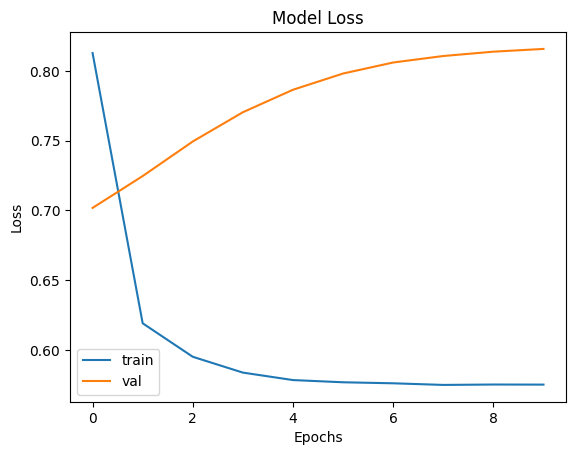

In [27]:
plt.plot(hist_3.history['loss'])
plt.plot(hist_3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

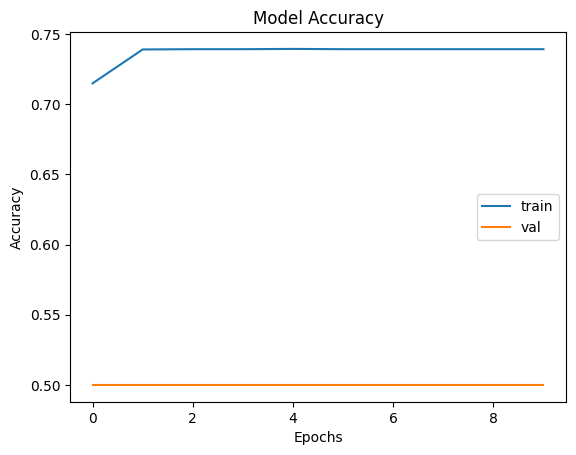

In [28]:
plt.plot(hist_3.history['accuracy'])
plt.plot(hist_3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

In [29]:
res_model.save("/content/drive/MyDrive/MODEL/RES_model.h5")
res_model.save("/content/drive/MyDrive/MODEL/RES_model.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INCEPTION V3


In [30]:
from tensorflow.keras.applications import InceptionV3

incept_model = InceptionV3(input_tensor=image_input,weights='imagenet', include_top=False)
incept_model.trainable=False
incept_model.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activatio

In [33]:
x = incept_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='sigmoid')(x)

# Create the final model
Inception_final_model = tf.keras.Model(inputs=incept_model.input, outputs=predictions)
Inception_final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Inception_final_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0]

In [34]:
hist_4=Inception_final_model.fit(training_set,
                       batch_size=32,
                       epochs=10,
                       validation_data=validation_set,
                       callbacks = callbacks_list,
                       verbose=1)

Epoch 1/10
165/165 [==============================] - 151s 875ms/step - loss: 0.3575 - accuracy: 0.8745 - val_loss: 0.2519 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 2/10
165/165 [==============================] - 136s 824ms/step - loss: 0.1787 - accuracy: 0.9272 - val_loss: 0.3155 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 3/10
165/165 [==============================] - 133s 806ms/step - loss: 0.1865 - accuracy: 0.9234 - val_loss: 0.4085 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 4/10
165/165 [==============================] - 136s 822ms/step - loss: 0.1650 - accuracy: 0.9377 - val_loss: 0.3577 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 5/10
165/165 [==============================] - 132s 801ms/step - loss: 0.1480 - accuracy: 0.9443 - val_loss: 0.3239 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 6/10
165/165 [==============================] - 133s 806ms/step - loss: 0.1374 - accuracy: 0.9489 - val_loss: 0.3190 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 7/10
165/165 [==========================

In [35]:
model4_loss,model4_accuracy=Inception_final_model.evaluate(test_set)

20/20 [==============================] - 8s 406ms/step - loss: 0.4993 - accuracy: 0.8349


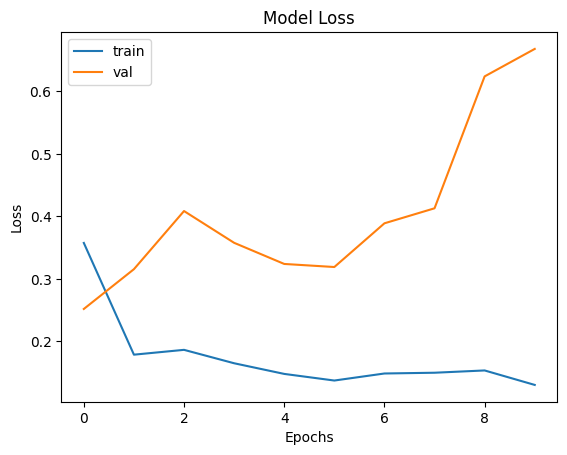

In [36]:
plt.plot(hist_4.history['loss'])
plt.plot(hist_4.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

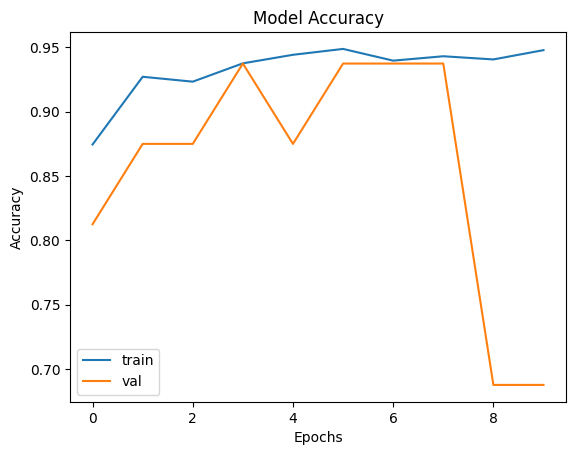

In [38]:
plt.plot(hist_4.history['accuracy'])
plt.plot(hist_4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

In [39]:
Inception_final_model.save("/content/drive/MyDrive/MODEL/INCEPTION_model.h5")
Inception_final_model.save("/content/drive/MyDrive/MODEL/INCEPTION_model.keras")